# TP 2 : Régression logistique

## 1 Régularisation de Tikhonov

### 1.1 : Étude de la fonction objectif :

**Calcul du gradient :**

$\frac{df_1}{dw_0} (w_0, w)= \frac 1 n \sum_{i=1}^n{\frac{-y_i}{1+exp(y_i(x_i^T*w + w_0))}}$


$\frac{df_1}{dw} (w_0, w)= \frac 1 n \sum_{i=1}^n{\frac{-y_i*x_i}{1+exp(y_i(x_i^T*w + w_0))}} + \rho * w$

**Calcul de la hessienne :**

$H = \frac 1 n * \sum_i{\frac{y_i^2}{(2cosh(y_i/2(x_i^T*w + w_0))^2}} * \begin{bmatrix}1 \\ x_i \end{bmatrix} \begin{bmatrix}1 \\ x_i \end{bmatrix}^T + \begin{vmatrix} 0 & 0 \\ 0 & {\rho * I_p} \end{vmatrix}  $

Montrons que $H$ est définie positive. Posons $a_i = \frac{y_i}{\sqrt n (2cosh(y_i/2(x_i^T*w + w_0))}$ et $v_i = \begin{bmatrix}1 \\ x_i \end{bmatrix}$, on a :

$\forall u \in \mathbb R^{p+1}, u^T H u = u^T \begin{vmatrix} 0 & 0 \\ 0 & {\rho * I_p} \end{vmatrix} u + \sum_i{(u^T a_i v_i) (v_i^T a_i u) }$

* $u^T \begin{vmatrix} 0 & 0 \\ 0 & {\rho * I_p} \end{vmatrix} u = \begin{bmatrix} 0 & {\rho \sum_{i=2}^{p+1}{u_i}} & {...} & {\rho \sum_{i=2}^{p+1}{u_i}} \end{bmatrix} \begin{bmatrix} u_1 \\ ... \\ u_ {p+1} \end{bmatrix} = \rho (\sum_{i=2}^{p+1}{u_i})^2 > 0$
* $\sum_i{(u^T a_i v_i) (v_i^T a_i u) } = \sum_i{(u^T a_i v_i)^2 } > 0$

Ainsi $ u^T H u > 0$. 

Et donc $f_1$ est convexe

### 1.2 : Programmation :

In [1]:
import numpy as np
from scipy.optimize import check_grad

def objective(w, X, Y, rho, verbose=False):
    """ Renvoie les données numériques du problème
    :param w: Le vecteur [w0 w] de l'énoncé. On attend une liste de longueur p+1.
    :param X: La matrice des vecteurs lignes xi. On attend une matrice de dimension n lignes * p+1 colonnes.
        La 1ère colonne est composée uniquement de 1.
    :param Y: Le vecteur des yi. Liste de longueur n.
    :param rho: Le paramètre de régularisation.
    
    :return: La valeur de la fonction, son gradient et sa hessienne."""
    assert (len(Y), len(w)) == X.shape, "Erreur de dimensions"
    n = len(Y)
    p = len(w) - 1
    # Valeur de la fonction au point w :
    val = rho/2 * np.linalg.norm(w, 2)**2
    for i in range(n):
        s = np.exp(-Y[i]*np.dot(X[i,:], w))
#         if verbose:
#             print("Étape %d, Val = %f" % (i, val))
#             print("s:", s)
        val += 1/n*np.log(1 + s)
    
    # Gradient de la fonction au point w 
    grad = np.zeros(p+1)
    grad[1:] = rho * w[1:]
    for i in range(n):
        grad += 1/n * (Y[i]*X[i])/(1 + np.exp(Y[i] * np.dot(X[i,:], w)))
        
    # Matrice hessienne :
    hess = np.identity(p+1)*rho
    hess[0,0] = 0
    for i in range(n):
        v = X[i,:][np.newaxis]
        hess += 1/n * (Y[i] / (2*np.cosh(Y[i]/(2*np.dot(X[i,:], w)))))**2 * v.T.dot(v)
#         if verbose:
#             print("v.T.dot(v):")
#             print(v.T.dot(v)[:10,:10])
#             print("hess[0,0] = %f" % hess[0,0])
#             print("np.dot(X[i,:], w) = %f" % np.dot(X[i,:], w))
#             print("(Y[i] / (2*np.cosh(Y[i]/(2*np.dot(X[i,:], w)))))**2 = %f"% 
#                   (Y[i] / (2*np.cosh(Y[i]/(2*np.dot(X[i,:], w)))))**2)
#             print("hess:")
#             print(hess)
    return val, grad, hess


In [2]:
from cervicalcancerutils import load_cervical_cancer


# Test unitaire :
y_test = np.array([-1, 1])
X_test = np.array([[1,0,1],[1,1,0]])
w_test = np.array([1,2,3])
rho_test = 1/2

print("Test unitaire :")
# f(w) :
val_expected = 1/2*(np.log(1+np.exp(4)) + np.log(1+np.exp(-3))) + rho_test/2 * 13
# hessienne :
a1 = 1/2 * (1/(2*np.cosh(-1/8)))**2
a2 = 1/2 * (1/(2*np.cosh(1/6)))**2
m1 = np.array([[1,0,1], [0,0,0], [1,0,1]])
m2 = np.array([[1,1,0], [1,1,0], [0,0,0]])
m3 = np.array([[0,0,0], [0,1,0], [0,0,1]])
hess_expected = a1*m1 + a2*m2 + rho_test * m3


val, grad, hess = objective(w_test, X_test, y_test, rho_test, verbose=False)
print("f(w) = %f, attendu : %f" % (val, val_expected))
print("Écart entre la hessienne et la valeur attendue :")
print(hess - hess_expected)

X,y = load_cervical_cancer("riskfactorscervicalcancer.csv")
(n, p) = X.shape

# On rajoute une colonne de 1 à X :
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Affichage des erreurs sur le gradient :
n_verif = 10 # Nombre de vérification à effectuer
print("Pour le gradient, avec les données 'cervical_cancer' :")
print("Écart absolu | Écart relatif")
print("----------------------------")
for i in range(n_verif):
    rho = np.random.random()
    w = np.random.random(p+1)
    f = lambda w:objective(w, X, y, rho)[0]
    grad_f = lambda w:objective(w, X, y, rho)[1]
    err = check_grad(f, grad_f, w)
    err_rel = err/np.linalg.norm(grad_f(w))
    print("%10.3f   | %5.1f%%" % (err, err_rel))

Test unitaire :
f(w) = 5.533369, attendu : 5.283369
Écart entre la hessienne et la valeur attendue :
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
Pour le gradient, avec les données 'cervical_cancer' :
Écart absolu | Écart relatif
----------------------------
     0.875   |   2.0%
     0.862   |   0.9%
     0.849   |   2.9%
     0.903   |   1.5%
     0.899   |   0.4%
     0.897   |   1.4%
     0.797   |   2.8%
     0.896   |   0.8%
     0.886   |   0.5%
     1.157   |   0.5%


In [3]:
print(np.linalg.inv(hess_expected))
print(np.linalg.inv(hess))

[[ 5.08736545 -0.99515305 -1.00484695]
 [-0.99515305  1.80343922  0.19656078]
 [-1.00484695  0.19656078  1.80343922]]
[[ 5.08736545 -0.99515305 -1.00484695]
 [-0.99515305  1.80343922  0.19656078]
 [-1.00484695  0.19656078  1.80343922]]


### 1.3 : Méthode de Newton :

Itération 10, val = 48.913834, ||grad|| = 0.542994
Itération 20, val = 378.533424, ||grad|| = 0.485724
Itération 30, val = 1017.933464, ||grad|| = 0.485714
Itération 40, val = 1967.216248, ||grad|| = 0.485714
Itération 50, val = 3226.385079, ||grad|| = 0.485714
Itération 60, val = 4795.440452, ||grad|| = 0.485714
Itération 70, val = 6674.382548, ||grad|| = 0.485714
Itération 80, val = 8863.211450, ||grad|| = 0.485714
Itération 90, val = 11361.927204, ||grad|| = 0.485714
Itération 100, val = 14170.529834, ||grad|| = 0.485714
Itération 110, val = 17289.019357, ||grad|| = 0.485714
Itération 120, val = 20717.395782, ||grad|| = 0.485714
Itération 130, val = 24455.659117, ||grad|| = 0.485714
Itération 140, val = 28503.809367, ||grad|| = 0.485714
Itération 150, val = 32861.846535, ||grad|| = 0.485714
Itération 160, val = 37529.770624, ||grad|| = 0.485714
Itération 170, val = 42507.581636, ||grad|| = 0.485714
Itération 180, val = 47795.279573, ||grad|| = 0.485714
Itération 190, val = 53392.864

/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in exp
/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in exp


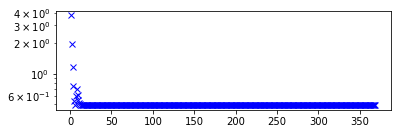

In [15]:
import math
import matplotlib.pyplot as plt

%matplotlib inline 

def newton(objective, start, epsilon=0.1, max_iter=1000,verbose=False):
    """ Renvoie le point qui minimise la fonction objectif.
    :param objective: une fonction qui prend un vecteur et renvoie (valeur, gradient, hessienne) en ce point.
    :param start: le point de départ
    
    :return: le point qui minimise la fonction.
    """
    proceed = True
    i = 1
    point = start
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    ax.set_yscale('log')
    while proceed:
        val, grad, hess = objective(point)
        norm_grad = np.linalg.norm(grad)
        
        ax.plot(i, norm_grad, 'bx')


        if verbose and i%10 == 0:
            print("Itération %d, val = %f, ||grad|| = %f" % (i, val, norm_grad))
        # Au lieu de faire x := x - np.linalg.inv(hess).dot(grad), on résout le système linéaire : 
        try:
            point -= np.linalg.solve(hess, grad)
        except LinAlgError:
            print("La hessienne n'est pas inversible, arrêt.")
            i = max_iter # pour arrêter

        i += 1
        proceed = i <= max_iter and norm_grad > epsilon and math.isfinite(val)
    
    return point

optimum = newton(lambda w:objective(w, X, y, rho, verbose=True), np.ones_like(w), epsilon=1e-10, verbose=True)

### Question 1.4 :

Itération 10, val = 40.902546, ||grad|| = 0.501110
Itération 20, val = 355.556324, ||grad|| = 0.485717
Itération 30, val = 980.027900, ||grad|| = 0.485714
Itération 40, val = 1914.382798, ||grad|| = 0.485714
Itération 50, val = 3158.623714, ||grad|| = 0.485714
Itération 60, val = 4712.751158, ||grad|| = 0.485714
Itération 70, val = 6576.765319, ||grad|| = 0.485714
Itération 80, val = 8750.666284, ||grad|| = 0.485714
Itération 90, val = 11234.454099, ||grad|| = 0.485714
Itération 100, val = 14028.128789, ||grad|| = 0.485714
Itération 110, val = 17131.690371, ||grad|| = 0.485714
Itération 120, val = 20545.138855, ||grad|| = 0.485714
Itération 130, val = 24268.474249, ||grad|| = 0.485714
Itération 140, val = 28301.696558, ||grad|| = 0.485714
Itération 150, val = 32644.805784, ||grad|| = 0.485714
Itération 160, val = 37297.801931, ||grad|| = 0.485714
Itération 170, val = 42260.685001, ||grad|| = 0.485714
Itération 180, val = 47533.454996, ||grad|| = 0.485714
Itération 190, val = 53116.1119

/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in exp


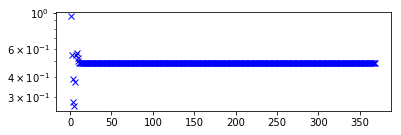

In [16]:
optimum = newton(lambda w:objective(w, X, y, rho, verbose=True), 0.3*np.ones_like(w), epsilon=1e-10, verbose=True)

On s'éloigne de l'optimum.

### 1.5 : Armijo

Itération 10, val = 1.044710, ||grad|| = 0.274893


/home/loic/.local/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: overflow encountered in cosh


Itération 20, val = 1.850945, ||grad|| = 0.297849
Itération 30, val = 4.928052, ||grad|| = 0.487834
Itération 40, val = 11.541982, ||grad|| = 0.566551
Itération 50, val = 21.544497, ||grad|| = 0.535752
Itération 60, val = 34.716102, ||grad|| = 0.511070
Itération 70, val = 50.995873, ||grad|| = 0.498222
Itération 80, val = 70.372491, ||grad|| = 0.491833
Itération 90, val = 92.844461, ||grad|| = 0.488698
Itération 100, val = 118.412206, ||grad|| = 0.487167
Itération 110, val = 147.076414, ||grad|| = 0.486421
Itération 120, val = 178.837702, ||grad|| = 0.486058
Itération 130, val = 213.696554, ||grad|| = 0.485882
Itération 140, val = 251.653332, ||grad|| = 0.485796
Itération 150, val = 292.708303, ||grad|| = 0.485754
Itération 160, val = 336.861659, ||grad|| = 0.485734
Itération 170, val = 384.113536, ||grad|| = 0.485724
Itération 180, val = 434.464033, ||grad|| = 0.485719
Itération 190, val = 487.913218, ||grad|| = 0.485717
Itération 200, val = 544.461142, ||grad|| = 0.485715
Itération 2

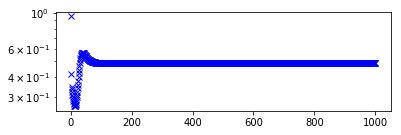

In [32]:
from scipy.optimize import minimize

def armijo(objective, start, epsilon=0.1, max_iter=1000,verbose=False):
    """ Renvoie le point qui minimise la fonction objectif.
    :param objective: une fonction qui prend un vecteur et renvoie (valeur, gradient, hessienne) en ce point.
    :param start: le point de départ
    
    :return: le point qui minimise la fonction.
    """
    proceed = True
    i = 1
    point = start
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    ax.set_yscale('log')
    while proceed:
        val, grad, hess = objective(point)
        norm_grad = np.linalg.norm(grad)
        
        ax.plot(i, norm_grad, 'bx')

        if verbose and i%10 == 0:
            print("Itération %d, val = %f, ||grad|| = %f" % (i, val, norm_grad))
        try:
            M = np.linalg.inv(hess).dot(grad)
            f = lambda l:objective(point - l[0]*M)[0]
            a_min = minimize(f, [1], bounds=((0.1, None),))['x'][0]
            point -= a_min*M
        except LinAlgError:
            print("La hessienne n'est pas inversible, arrêt.")
            i = max_iter # pour arrêter

        i += 1
        proceed = i <= max_iter and norm_grad > epsilon and math.isfinite(val)
    
    return point


optimum = armijo(lambda w:objective(w, X, y, rho, verbose=True), 0.3*np.ones_like(w), epsilon=1e-10, verbose=True)

## Partie 2 : 

### 2.1 : 
La norme 1 empèche la différenciabilité.

### 2.2 : 

** Calcul de l'opérateur proximal :**


On a $g_2:w \mapsto \rho ||w||_1$, son opérateur proximal est le seuillage doux : 

Soit $ w \in \mathbb R^p$ et  $v = prox_{g_2}(w)$, on cherche $v$ tel que $0 \in d F(v)$ avec $F:x \mapsto g_2(x) + \frac{||x-w||^2}{2}$.

On a : $dF(x) = dg(x) + x-w$
avec $u \in dg(x) \Leftrightarrow u_i = \begin{cases}
    \{\rho\}, & \text{si $x_i > 0$}.\\
    \{-\rho\}, & \text{si $x_i < 0$}.\\
    [-\rho, +\rho], & \text{si $x_i = 0$}.
  \end{cases}$

Ainsi $0 \in dF(v) \Leftrightarrow 0 \in dg(v) + v-w \Leftrightarrow w-v \in dg(v) $.

C'est-à-dire : 

$w_i - v_i = \begin{cases}
    \{\rho\}, & \text{si $v_i > 0$}.\\
    \{-\rho\}, & \text{si $v_i < 0$}.\\
    [-\rho, +\rho], & \text{si $v_i = 0$}.
  \end{cases}$
  
Ou encore : 
$ v_i = \begin{cases}
    w_i - \rho, & \text{si $w_i - \rho> 0$}.\\
    w_i + \rho, & \text{si $w_i + \rho < 0$}.\\
    0, & \text{si $w_i \in [-\rho, +\rho]$}.
  \end{cases}$
  

** Calcul du gradient de $f_2$ : **

$\frac{df_2}{dw_0} (w_0, w)= \frac 1 n \sum_{i=1}^n{\frac{-y_i}{1+exp(y_i(x_i^T*w + w_0))}}$


$\frac{df_2}{dw} (w_0, w)= \frac 1 n \sum_{i=1}^n{\frac{-y_i*x_i}{1+exp(y_i(x_i^T*w + w_0))}} $
